## Data

The preprocessed data can be fetched by calling [fetch_401K()](https://docs.doubleml.org/stable/api/generated/doubleml.datasets.fetch_401K.html#doubleml.datasets.fetch_401K). Note that an internet connection is required for loading the data.

In [157]:
import numpy as np
import pandas as pd
import doubleml as dml
from doubleml.datasets import fetch_401K

from scipy import stats as st

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.inspection import permutation_importance

from xgboost import XGBClassifier, XGBRegressor

import matplotlib.pyplot as plt
import seaborn as sns

import neo4j
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
from IPython.display import display
import graphviz as gv

import warnings
warnings.filterwarnings("ignore")

In [2]:
sns.set()
colors = sns.color_palette()

In [3]:
plt.rcParams['figure.figsize'] = 10., 7.5
sns.set(font_scale=1.5)
sns.set_style('whitegrid', {'axes.spines.top': False,
                            'axes.spines.bottom': False,
                            'axes.spines.left': False,
                            'axes.spines.right': False})

In [4]:
data = fetch_401K(return_type='DataFrame')
data.columns

Index(['nifa', 'net_tfa', 'tw', 'age', 'inc', 'fsize', 'educ', 'db', 'marr',
       'twoearn', 'e401', 'p401', 'pira', 'hown'],
      dtype='object')

In [106]:
desc = data.describe().round(3).T
desc

,count,mean,std,min,25%,50%,75%,max
nifa,9915.0,13928.614,54905.043,0.0,200.0,1635.0,8765.5,1430298.0
net_tfa,9915.0,18051.502,63522.590,-502302.0,-500.0,1499.0,16524.5,1536798.0
tw,9915.0,63816.855,111529.648,-502302.0,3291.5,25100.0,81487.5,2029910.0
age,9915.0,41.060,10.345,25.0,32.0,40.0,48.0,64.0
inc,9915.0,37200.621,24774.252,-2652.0,19413.0,31476.0,48583.5,242124.0
fsize,9915.0,2.866,1.539,1.0,2.0,3.0,4.0,13.0
educ,9915.0,13.206,2.810,1.0,12.0,12.0,16.0,18.0
db,9915.0,0.271,0.445,0.0,0.0,0.0,1.0,1.0
marr,9915.0,0.605,0.489,0.0,0.0,1.0,1.0,1.0
twoearn,9915.0,0.381,0.486,0.0,0.0,0.0,1.0,1.0


## Now upload the descriptive stats into Neo4j wellbeing2kg database

In [130]:
col_names = {
    'nifa': 'net non-401(k) assets (nifa)',
    'net_tfa': 'net financial assets (net_tfa)',
    'tw': 'total wealth (tw)',
    'age': 'age',
    'inc': 'income (inc)',
    'fsize': 'family size (fsize)',
    'educ': 'years of education (educ)',
    'db': 'defined benefit pension (db)',
    'marr': 'married (marr)',
    'twoearn': 'both earning jobs (twoearn)',
    'e401': '401(k) eligibility (e401)',
    'p401': '401(k) participation (p401)',
    'pira': 'participation in IRA (pira)',
    'hown': 'home ownership (hown)'
}

In [131]:
def my_neo4j_wipe_out_database_401k():
    "wipe out database by deleting all nodes and relationships where node.paper_id='DML'"
    
    query = "match (node)-[relationship]-() where node.paper_id='DML' delete node, relationship"
    session.run(query)
    
    query = "match (node) where node.paper_id='DML' delete node"
    session.run(query)

In [158]:
driver = neo4j.GraphDatabase.driver(uri="bolt://localhost:11003", auth=("neo4j","GoPeaks"))
session = driver.session(database="neo4j")

In [133]:
my_neo4j_wipe_out_database_401k()
query = "match (node) where node.paper_id='DML' return node"
pd.DataFrame(session.run(query))

""


In [134]:
print(data.columns)

for i in data.columns:

    if i == "age":     
        nm = str(i)
        l1 = "person"
        l2 = "demographics"
        l3 = "age"
        sc = "DoubleML"
        pr = "DML"
        
    elif i =="fsize":
        nm = str(i)
        l1 = "person"
        l2 = "demographics"
        l3 = "family"
        sc = "DoubleML"
        pr = "DML"        

    elif i =="educ":
        nm = str(i)
        l1 = "person"
        l2 = "ability"
        l3 = "education"
        sc = "DoubleML"
        pr = "DML"
        
    elif i =="marr":
        nm = str(i)
        l1 = "person"
        l2 = "demographics"
        l3 = "marrital status"
        sc = "DoubleML"
        pr = "DML"
        
    else:
        nm = str(i)
        l1 = "well-being, economic"
        l2 = "economic reward"
        l3 = "wealth"
        sc = "DoubleML"
        pr = "DML"
        
    tags = "{" + f"name: \"{nm}\", "
    tags += f"label1: \"{l1}\", "
    tags += f"label2: \"{l2}\", "
    tags += f"label3: \"{l3}\", "
    tags += f"source: \"{sc}\", "
    tags += f"paper_id: \"{pr}\""
    tags += "}"
    
    query = f"CREATE (c: construct {tags})"

    session.run(query)

Index(['nifa', 'net_tfa', 'tw', 'age', 'inc', 'fsize', 'educ', 'db', 'marr',
       'twoearn', 'e401', 'p401', 'pira', 'hown'],
      dtype='object')


In [135]:
print(desc.index)

for i in desc.index:
    
    nm_r = str(i)
    nm = str(i)
    de = str(col_names[i])
    miu = str(desc.loc[i]['mean'])
    std = str(desc.loc[i]['std'])
    alpha = ""
    sc = "DoubleML"
    pr = "DML"
    
    tags = "{" + f"name: \"{nm}\", "
    tags += f"name_raw: \"{nm_r}\", "
    tags += f"description: \"{de}\", "
    tags += f"mean: \"{miu}\", "
    tags += f"std: \"{std}\", "
    tags += f"alpha: \"{alpha}\", "
    tags += f"source: \"{sc}\", "
    tags += f"paper_id: \"{pr}\""
    tags += "}"
    
    query = f"CREATE (v: variable {tags})"

    session.run(query)

Index(['nifa', 'net_tfa', 'tw', 'age', 'inc', 'fsize', 'educ', 'db', 'marr',
       'twoearn', 'e401', 'p401', 'pira', 'hown'],
      dtype='object')


In [136]:
edges_theory = pd.DataFrame(columns=['v1_name', 'v2_name', 'source', 'paperid', 'theory', 'hypothesis', 'hypothesis_id'])

v=['age', 'inc', 'fsize', 'educ', 'db', 'marr', 'twoearn','pira', 'hown']
for i in v:
    add = {'v1_name': i, 
           'v2_name': 'e401', 
           'source': 'DoubleML', 
           'paperid': 'DML', 
           'theory': '', 
           'hypothesis': '',
           'hypothesis_id': ''}
    edges_theory = edges_theory.append(add, ignore_index = True)
    
for i in v:
    add = {'v1_name': i, 
           'v2_name': 'net_tfa', 
           'source': 'DoubleML', 
           'paperid': 'DML', 
           'theory': '', 
           'hypothesis': '',
           'hypothesis_id': ''}
    edges_theory = edges_theory.append(add, ignore_index = True)

for i in v:
    add = {'v1_name': i, 
           'v2_name': 'nifa', 
           'source': 'DoubleML', 
           'paperid': 'DML', 
           'theory': '', 
           'hypothesis': '',
           'hypothesis_id': ''}
    edges_theory = edges_theory.append(add, ignore_index = True)
    
v=['nifa', 'net_tfa', 'p401']
for i in v:
    add = {'v1_name': 'e401', 
           'v2_name': i, 
           'source': 'DoubleML', 
           'paperid': 'DML', 
           'theory': '', 
           'hypothesis': '',
           'hypothesis_id': ''}
    edges_theory = edges_theory.append(add, ignore_index = True)

v=['nifa', 'net_tfa']
for i in v:
    add = {'v1_name': 'p401', 
           'v2_name': i, 
           'source': 'DoubleML', 
           'paperid': 'DML', 
           'theory': '', 
           'hypothesis': '',
           'hypothesis_id': ''}
    edges_theory = edges_theory.append(add, ignore_index = True)

    add = {'v1_name': i, 
           'v2_name': 'tw', 
           'source': 'DoubleML', 
           'paperid': 'DML', 
           'theory': '', 
           'hypothesis': '',
           'hypothesis_id': ''}
    edges_theory = edges_theory.append(add, ignore_index = True)

edges_theory

,v1_name,v2_name,source,paperid,theory,hypothesis,hypothesis_id
0,age,e401,DoubleML,DML,,,
1,inc,e401,DoubleML,DML,,,
2,fsize,e401,DoubleML,DML,,,
3,educ,e401,DoubleML,DML,,,
4,db,e401,DoubleML,DML,,,
5,marr,e401,DoubleML,DML,,,
6,twoearn,e401,DoubleML,DML,,,
7,pira,e401,DoubleML,DML,,,
8,hown,e401,DoubleML,DML,,,
9,age,net_tfa,DoubleML,DML,,,


In [137]:
for i in edges_theory.index:
    
    sc = str(edges_theory.iloc[i]['source'])
    pr = str(edges_theory.iloc[i]['paperid'])
    th = str(edges_theory.iloc[i]['theory'])
    hypo_id = str(edges_theory.iloc[i]['hypothesis_id'])
    hypo = str(edges_theory.iloc[i]['hypothesis'])
    
    c1nm = str(edges_theory.iloc[i]['v1_name'])
    c2nm = str(edges_theory.iloc[i]['v2_name'])
    
    match = f"WHERE c1.name = \"{c1nm}\" AND c2.name = \"{c2nm}\" "
    match += f"AND c1.source = \"{sc}\" AND c2.source = \"{sc}\" "
    match += f"AND c1.paper_id = \"{pr}\" AND c2.paper_id = \"{pr}\""
    
    tags = "{" + f"source: \"{sc}\", "
    tags += f"paper_id: \"{pr}\", "
    tags += f"theory: \"{th}\", "
    tags += f"hypothesis_id: \"{hypo_id}\", "
    tags += f"hypothesis: \"{hypo}\""
    tags += "}"
    
    query = f"""
    MATCH (c1: construct), (c2: construct)
    {match}
    CREATE (c1)-[r:causes {tags}]->(c2)
    """
    session.run(query)

In [138]:
for i in desc.index:
    
    nm_r = str(i)
    nm = str(i)
    de = str(col_names[i])
    miu = str(desc.loc[i]['mean'])
    std = str(desc.loc[i]['std'])
    alpha = ""
    sc = "DoubleML"
    pr = "DML"
    
    match = f"WHERE c.name = \"{nm}\" AND v.name = \"{nm}\" "
    match += f"AND v.name_raw = \"{nm_r}\" "
    match += f"AND v.description = \"{de}\""
    
    tags = "{" + f"source: \"{sc}\", "
    tags += f"paper_id: \"{pr}\""
    tags += "}"
    
    query = f"""
    MATCH (v: variable), (c: construct)
    {match}
    CREATE (v)-[r:measures {tags}]->(c)
    """
    session.run(query)

In [154]:
edges_evidence = data.corr().stack().reset_index()
edges_evidence.columns = ['v1', 'v2', 'correlation']
for v in ['v1', 'v2']:
    edges_evidence[v+'_name'] = edges_evidence[v]
    edges_evidence[v+'_description'] = None
    for i in edges_evidence[v].unique():
        edges_evidence.loc[edges_evidence[v]==i, v+'_description'] = col_names[i]
edges_evidence['source'] = "DoubleML"
edges_evidence['paperid'] = "DML"
edges_evidence['sample_size'] = "9915"
edges_evidence['sample_years'] = "1991"
edges_evidence['sample_country'] = "United States"
edges_evidence['sample_industry'] = "Financial services"
edges_evidence = edges_evidence[edges_evidence.v1 != edges_evidence.v2]
edges_evidence = edges_evidence.reset_index(drop=True)
edges_evidence

,v1,v2,correlation,v1_name,v1_description,v2_name,v2_description,source,paperid,sample_size,sample_years,sample_country,sample_industry
0,nifa,net_tfa,0.940527,nifa,net non-401(k) assets (nifa),net_tfa,net financial assets (net_tfa),DoubleML,DML,9915,1991,United States,Financial services
1,nifa,tw,0.712796,nifa,net non-401(k) assets (nifa),tw,total wealth (tw),DoubleML,DML,9915,1991,United States,Financial services
2,nifa,age,0.148034,nifa,net non-401(k) assets (nifa),age,age,DoubleML,DML,9915,1991,United States,Financial services
3,nifa,inc,0.328198,nifa,net non-401(k) assets (nifa),inc,income (inc),DoubleML,DML,9915,1991,United States,Financial services
4,nifa,fsize,-0.026230,nifa,net non-401(k) assets (nifa),fsize,family size (fsize),DoubleML,DML,9915,1991,United States,Financial services
...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,hown,marr,0.313586,hown,home ownership (hown),marr,married (marr),DoubleML,DML,9915,1991,United States,Financial services
178,hown,twoearn,0.236226,hown,home ownership (hown),twoearn,both earning jobs (twoearn),DoubleML,DML,9915,1991,United States,Financial services
179,hown,e401,0.170071,hown,home ownership (hown),e401,401(k) eligibility (e401),DoubleML,DML,9915,1991,United States,Financial services
180,hown,p401,0.160788,hown,home ownership (hown),p401,401(k) participation (p401),DoubleML,DML,9915,1991,United States,Financial services


In [155]:
for i in edges_evidence.index:
    
    sc = str(edges_evidence.iloc[i]['source'])
    pr = str(edges_evidence.iloc[i]['paperid'])
    N = str(edges_evidence.iloc[i]['sample_size'])
    time = str(edges_evidence.iloc[i]['sample_years'])
    place = str(edges_evidence.iloc[i]['sample_country'])
    ind = str(edges_evidence.iloc[i]['sample_industry'])
    corr = str(edges_evidence.iloc[i]['correlation'])
    
    v1 = str(edges_evidence.iloc[i]['v1'])
    v2 = str(edges_evidence.iloc[i]['v2'])
    v1nm = str(edges_evidence.iloc[i]['v1_name'])
    v2nm = str(edges_evidence.iloc[i]['v2_name'])
    v1de = str(edges_evidence.iloc[i]['v1_description'])
    v2de = str(edges_evidence.iloc[i]['v2_description'])
    
    match = f"WHERE v1.name_raw = \"{v1}\" AND v2.name_raw = \"{v2}\" "
    match += f"AND v1.name = \"{v1nm}\" AND v2.name = \"{v2nm}\" "
    match += f"AND v1.description = \"{v1de}\" AND v2.description = \"{v2de}\""
    
    tags = "{" + f"source: \"{sc}\", "
    tags += f"paper_id: \"{pr}\", "
    tags += f"sample_size: \"{N}\", "
    tags += f"sample_years: \"{time}\", "
    tags += f"sample_countries: \"{place}\", "
    tags += f"sample_industries: \"{ind}\", "
    tags += f"correlation: \"{corr}\""
    tags += "}"
    
    query = f"""
    MATCH (v1: variable), (v2: variable)
    {match}
    CREATE (v1)-[r:correlates_with {tags}]->(v2)
    """
    session.run(query)

In [156]:
# Correlation is both-way, so duplicate all the correlations for the other direction again.

for i in edges_evidence.index:
    
    sc = str(edges_evidence.iloc[i]['source'])
    pr = str(edges_evidence.iloc[i]['paperid'])
    N = str(edges_evidence.iloc[i]['sample_size'])
    time = str(edges_evidence.iloc[i]['sample_years'])
    place = str(edges_evidence.iloc[i]['sample_country'])
    ind = str(edges_evidence.iloc[i]['sample_industry'])
    corr = str(edges_evidence.iloc[i]['correlation'])
    
    v1 = str(edges_evidence.iloc[i]['v1'])
    v2 = str(edges_evidence.iloc[i]['v2'])
    v1nm = str(edges_evidence.iloc[i]['v1_name'])
    v2nm = str(edges_evidence.iloc[i]['v2_name'])
    v1de = str(edges_evidence.iloc[i]['v1_description'])
    v2de = str(edges_evidence.iloc[i]['v2_description'])
    
    match = f"WHERE v1.name_raw = \"{v1}\" AND v2.name_raw = \"{v2}\" "
    match += f"AND v1.name = \"{v1nm}\" AND v2.name = \"{v2nm}\" "
    match += f"AND v1.description = \"{v1de}\" AND v2.description = \"{v2de}\""
    
    tags = "{" + f"source: \"{sc}\", "
    tags += f"paper_id: \"{pr}\", "
    tags += f"sample_size: \"{N}\", "
    tags += f"sample_years: \"{time}\", "
    tags += f"sample_countries: \"{place}\", "
    tags += f"sample_industries: \"{ind}\", "
    tags += f"correlation: \"{corr}\""
    tags += "}"
    
    query = f"""
    MATCH (v1: variable), (v2: variable)
    {match}
    CREATE (v2)-[r:correlates_with {tags}]->(v1)
    """
    session.run(query)

Query and show a Causal Graph

In [178]:
def summary_graph(edges):

    nodes1 = edges['c1.name'].drop_duplicates()
    nodes2 = edges['c2.name'].drop_duplicates()
    nodes = pd.concat([nodes1, nodes1], ignore_index=True).drop_duplicates()

    G = gv.Digraph('summary', format='png')

    for i, j in zip(edges['c1.name'], edges['c2.name']):
        w = float(edges.loc[(edges['c1.name']==i) & (edges['c2.name']==j), 'correlation'])
        p = float(edges.loc[(edges['c1.name']==i) & (edges['c2.name']==j), 'p-value'])
        w = round(w, 3)
        p = round(p, 2)
        if w == 0:
            continue
        elif w < 0:
            G.edge(i, j, **{'penwidth':str(abs(w)*10), 'color': 'red', 'label': f"{w} ({p})"})
        elif w > 0:
            G.edge(i, j, **{'penwidth':str(w*10), 'color': 'green', 'label': f"{w} ({p})"})

    G.render()
    
    note ="""
    Notes: 
    [1] link label shows the mean effect size (p-value in the parenthesis); 
    [2] link arrow shows the direction of causality; 
    [3] link color suggests the sign of the effect size: green for positive, and red for negative;
    [4] link thickness suggests the magnitude of the effect size.
    """
    
    from IPython.display import display, Image
    display(Image(filename='Summary.gv.png'))
    print(note)

In [172]:
import scipy.stats

results_tab = pd.DataFrame({'c1.name': [],
                            'c2.name': [],
                            'correlation': [],
                            'p-value': []
                           })

path = """MATCH p_c12 = (c1:construct)-[c12:causes]->(c2:construct)
MATCH p_m1 = (v1:variable)-[m1:measures]->(c1:construct)
MATCH p_m2 = (v2:variable)-[m2:measures]->(c2:construct)
MATCH p_r12 = (v1:variable)-[r12:correlates_with]->(v2:variable)
"""

results = "c1.name, c2.name, r12.correlation, r12.sample_size"

query = f"""
{path}
WHERE c12.paper_id='DML'
RETURN {results}
"""

results_tab_add = pd.DataFrame(session.run(query)).drop_duplicates().reset_index(drop=True)
results_tab_add.columns = ['c1.name', 'c2.name', 'correlation', 'sample_size']
for i, j in zip(results_tab_add['c1.name'], results_tab_add['c2.name']):
    n = int(results_tab_add.loc[(results_tab_add['c1.name']==i) & (results_tab_add['c2.name']==j), 'sample_size'])
    dist = scipy.stats.beta(n/2 - 1, n/2 - 1, loc=-1, scale=2)
    r = float(results_tab_add.loc[(results_tab_add['c1.name']==i) & (results_tab_add['c2.name']==j), 'correlation'])
    results_tab_add.loc[(results_tab_add['c1.name']==i) & (results_tab_add['c2.name']==j), 
                        'p-value'] = 2*dist.cdf(-abs(r))

results_tab = pd.concat([results_tab,results_tab_add], ignore_index=True)

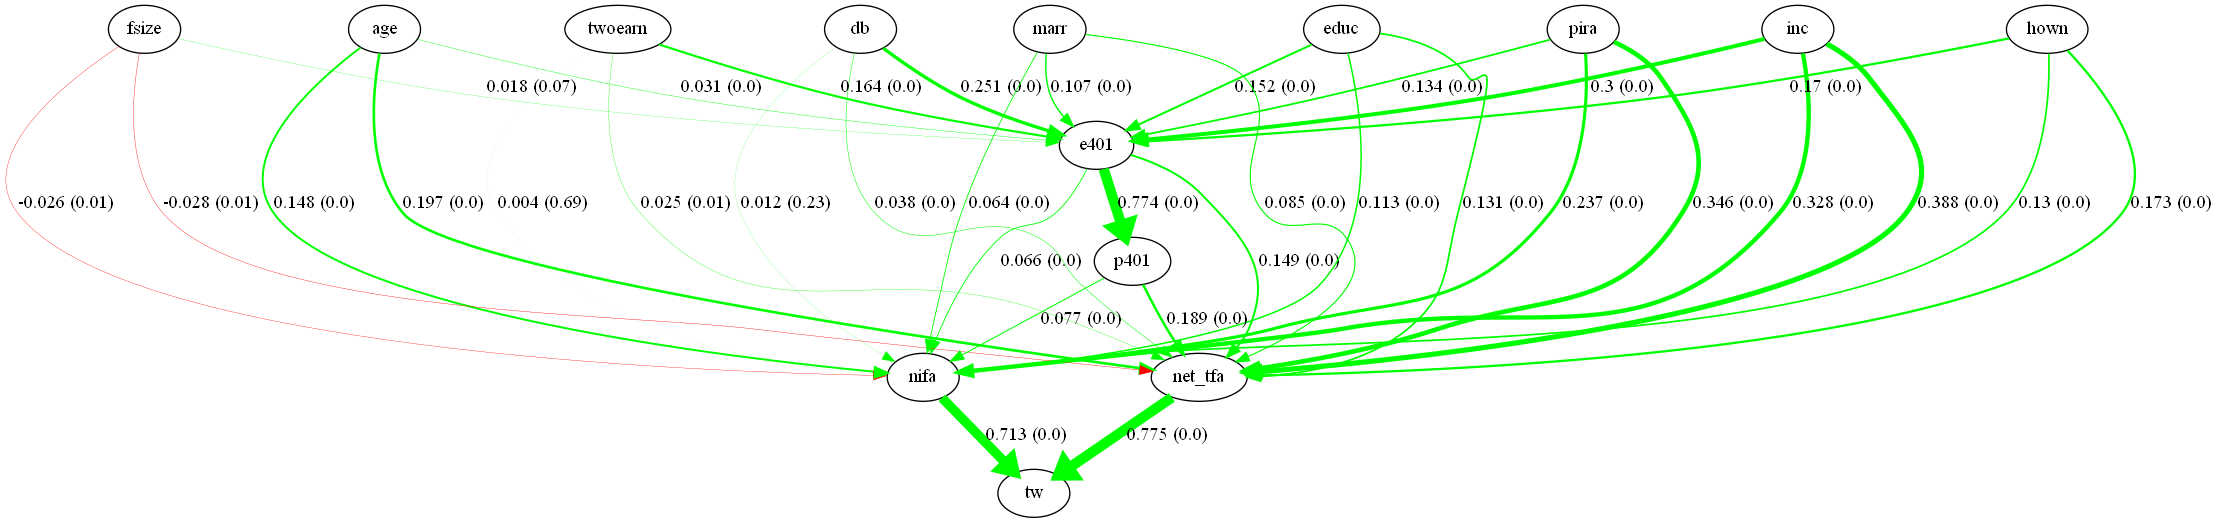


    Notes: 
    [1] link label shows the mean effect size (p-value in the parenthesis); 
    [2] link arrow shows the direction of causality; 
    [3] link color suggests the sign of the effect size: green for positive, and red for negative;
    [4] link thickness suggests the magnitude of the effect size.
    


In [179]:
summary_graph(results_tab)